In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../Task 1/')
from efficient_apriori import apriori
from improved_apriori import Improved_Apriori
from kmodes.kmodes import KModes
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
data = pd.read_csv('../Task 2/dataset/final_animedataset.csv')
data = data[['username', 'title']]
data = data.groupby('username')['title'].apply(list)
data = data.to_dict()

In [3]:
# Step 2: Frequent Itemset Generation
# Use the apriori algorithm to generate frequent itemsets
apriori = Improved_Apriori(data, min_support=0.4, min_confidence=1)
frequent_itemsets = apriori.apriori()
frequent_itemsets

100%|██████████| 78/78 [00:01<00:00, 52.98it/s]
0it [00:00, ?it/s]


{1: {('Angel Beats!',): 65303,
  ('Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.',): 49456,
  ('Another',): 51658,
  ('Ao no Exorcist',): 53028,
  ('Bakemonogatari',): 57273,
  ('Bleach',): 63861,
  ('Byousoku 5 Centimeter',): 47041,
  ('Clannad',): 63023,
  ('Clannad: After Story',): 50104,
  ('Code Geass: Hangyaku no Lelouch',): 71414,
  ('Code Geass: Hangyaku no Lelouch R2',): 58654,
  ('Cowboy Bebop',): 51706,
  ('Darker than Black: Kuro no Keiyakusha',): 51982,
  ('Death Note',): 85642,
  ('Durarara!!',): 59267,
  ('Elfen Lied',): 68075,
  ('Fairy Tail',): 53143,
  ('Fate/stay night',): 48914,
  ('Fullmetal Alchemist',): 61241,
  ('Fullmetal Alchemist: Brotherhood',): 67132,
  ('Highschool of the Dead',): 55774,
  ('Higurashi no Naku Koro ni',): 49684,
  ('K-On!',): 50388,
  ('Mahou Shoujo Madoka★Magica',): 48549,
  ('Mirai Nikki (TV)',): 57010,
  ('Naruto',): 66343,
  ('Naruto: Shippuuden',): 53626,
  ('Neon Genesis Evangelion',): 52984,
  ('No Game No Life',): 48171,


In [4]:
# Create a binary matrix
# Flatten the dictionary into a list of itemsets
from tqdm import tqdm
itemsets = [itemset for level in frequent_itemsets.values() for itemset in level.keys()]

# Transactions 
transactions = list(data.values())

binary_matrix = pd.DataFrame(0, index=range(len(transactions)), columns=itemsets)

# Fill in the binary matrix
for i, transaction in enumerate(tqdm(transactions)):
    for itemset in itemsets:
        if set(itemset).issubset(transaction):
            binary_matrix.at[i, itemset] = 1  # Use 'at' instead of 'loc' for scalar indexing

binary_matrix


  0%|          | 0/116124 [00:00<?, ?it/s]

100%|██████████| 116124/116124 [03:08<00:00, 616.63it/s]


,"(Angel Beats!,)","(Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,)","(Another,)","(Ao no Exorcist,)","(Bakemonogatari,)","(Bleach,)","(Byousoku 5 Centimeter,)","(Clannad,)","(Clannad: After Story,)","(Code Geass: Hangyaku no Lelouch,)",...,"(Naruto, Naruto: Shippuuden)","(Shingeki no Kyojin, Steins;Gate)","(Shingeki no Kyojin, Sword Art Online)","(Shingeki no Kyojin, Toradora!)","(Steins;Gate, Sword Art Online)","(Sword Art Online, Toradora!)","(Code Geass: Hangyaku no Lelouch, Code Geass: Hangyaku no Lelouch R2, Death Note)","(Code Geass: Hangyaku no Lelouch, Death Note, Elfen Lied)","(Code Geass: Hangyaku no Lelouch, Death Note, Fullmetal Alchemist: Brotherhood)","(Death Note, Shingeki no Kyojin, Sword Art Online)"
0,0,0,0,0,0,0,1,1,0,1,...,1,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,1,0,0,1,0,0,...,1,1,1,1,1,1,0,0,0,1
4,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116119,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
116120,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,1,0,0
116121,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,0,1,1
116122,1,1,1,0,0,0,0,1,1,1,...,0,1,1,0,1,0,0,0,0,0


In [5]:
def kmodes_elbow_method(data, max_k=5, figsize=(15, 8)):
    cost = []
    silhouette_scores = []
    plt.figure(figsize=figsize)
    # Loop through different values of k
    for k in tqdm(range(2, max_k+1)):
        kmodes = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
        
        # Fit the k-modes clustering model to the data
        kmodes.fit(data)
        
        # Calculate the cost
        cost.append(kmodes.cost_)
        
        # Calculate the average silhouette score
        silhouette_scores.append(silhouette_score(data, kmodes.labels_))
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Cost', color='b')
    ax1.plot(range(2, max_k+1), cost, 'bo-')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette score', color='r')
    ax2.plot(range(2, max_k+1), silhouette_scores, 'ro-')
    
    fig.tight_layout()
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [2:46:24<00:00, 2496.12s/it]


<Figure size 1080x576 with 0 Axes>

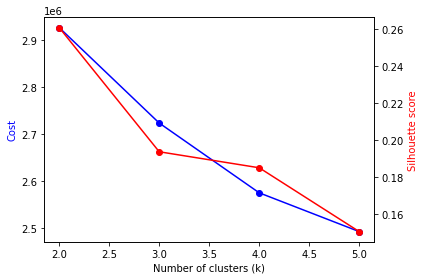

In [6]:
kmodes_elbow_method(binary_matrix)

In [7]:
# Number of clusters for K-Modes to be 4
k = 4
kmodes = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
kmodes.fit(binary_matrix)
cluster_labels = kmodes.labels_
kmodes_centroids = kmodes.cluster_centroids_

# kmodes_silhouette = silhouette_score(binary_matrix, cluster_labels)

# plt.figure(figsize=(15,10))
# for i in range(k):
#     plt.scatter(binary_matrix[cluster_labels == i, 0], binary_matrix[cluster_labels == i, 1], label='Cluster '+str(i))
# plt.legend()

# # Plot the centroids
# plt.scatter(kmodes_centroids[:, 0], kmodes_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
# plt.title('Visualization of clustered data')
# plt.show()

InvalidIndexError: (array([ True, False, False, ..., False, False,  True]), 0)

<Figure size 1080x720 with 0 Axes>

In [8]:
cluster_labels

array([0, 3, 3, ..., 2, 3, 0], dtype=uint16)

In [10]:
binary_matrix['clusters'] = cluster_labels
binary_matrix

,"(Angel Beats!,)","(Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,)","(Another,)","(Ao no Exorcist,)","(Bakemonogatari,)","(Bleach,)","(Byousoku 5 Centimeter,)","(Clannad,)","(Clannad: After Story,)","(Code Geass: Hangyaku no Lelouch,)",...,"(Shingeki no Kyojin, Steins;Gate)","(Shingeki no Kyojin, Sword Art Online)","(Shingeki no Kyojin, Toradora!)","(Steins;Gate, Sword Art Online)","(Sword Art Online, Toradora!)","(Code Geass: Hangyaku no Lelouch, Code Geass: Hangyaku no Lelouch R2, Death Note)","(Code Geass: Hangyaku no Lelouch, Death Note, Elfen Lied)","(Code Geass: Hangyaku no Lelouch, Death Note, Fullmetal Alchemist: Brotherhood)","(Death Note, Shingeki no Kyojin, Sword Art Online)",clusters
0,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,1,0,1,1,1,0,0,1,0,0,...,1,1,1,1,1,0,0,0,1,1
4,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116119,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,3
116120,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,1,0,0,0
116121,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,0,1,1,2
116122,1,1,1,0,0,0,0,1,1,1,...,1,1,0,1,0,0,0,0,0,3
